# Agriculture Prices

Some links to data:
* [Commodity Prices 1960-2022 (Kaggle)](https://www.kaggle.com/datasets/utkarshx27/select-world-bank-commodity-price-data)
* [Commidity Prices 1960-2021 (Kaggle, slightly different than the previous)](https://www.kaggle.com/datasets/elmoallistair/commodity-prices-19602021)
* [Agricultural Futures Prices (Kaggle, originally Yahoo Finance)](https://www.kaggle.com/datasets/guillemservera/agricultural-futures)

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
import statsmodels.api as sm

In [6]:
corn = yf.Ticker('ZCH25.CBT')
df_corn = corn.history(period = 'max')
df_corn

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-14 00:00:00-05:00,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15 00:00:00-05:00,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16 00:00:00-05:00,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19 00:00:00-05:00,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20 00:00:00-05:00,570.00,570.00,565.50,565.50,1,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-10 00:00:00-05:00,485.75,492.75,482.25,491.50,250904,0.0,0.0
2025-02-11 00:00:00-05:00,491.75,497.00,483.25,484.00,311257,0.0,0.0
2025-02-12 00:00:00-05:00,483.75,492.25,481.50,490.25,271391,0.0,0.0


In [3]:
wheat = yf.Ticker('KE=F') # KEH25, KE=F
df_wheat = wheat.history(period='max')

In [4]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i]['Close']))
    sigmas = np.insert(sigmas, 0, np.full((n), 0))
    return sigmas


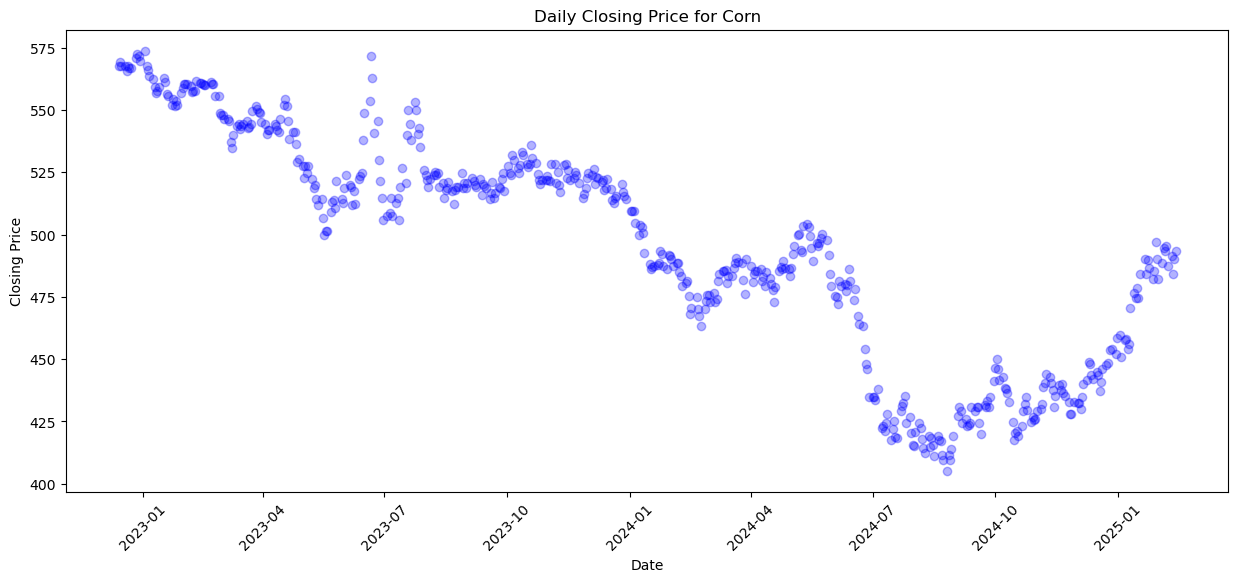

In [5]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_corn.index, df_corn['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Corn')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [6]:
rolling_sigmas_corn = volatilities(df_corn,n=30)

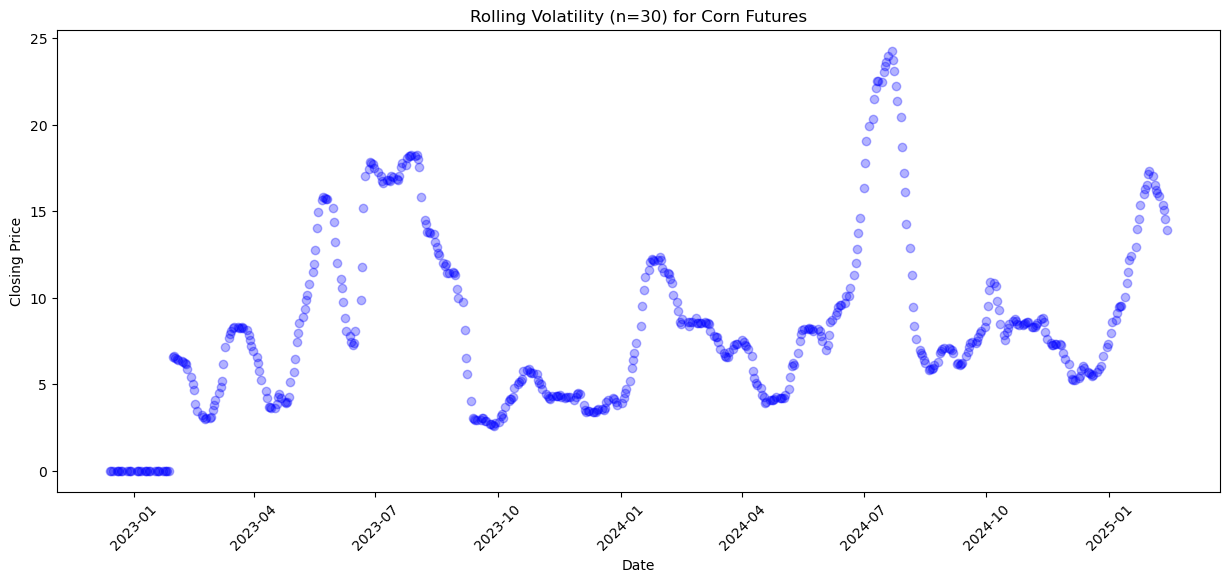

In [7]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_corn.index, rolling_sigmas_corn, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30) for Corn Futures')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

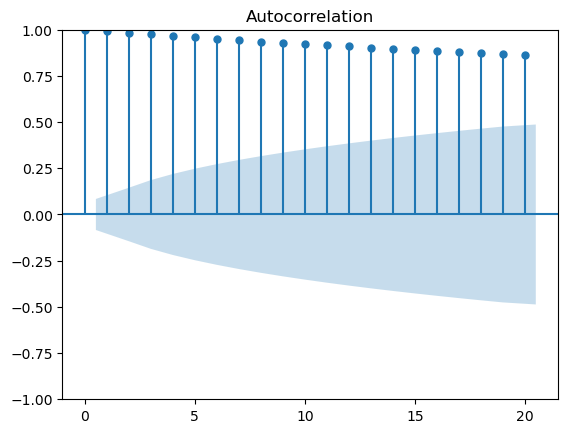

In [8]:
sm.graphics.tsa.plot_acf(df_corn['Close'], lags = 20) # correlation between X and a delayed copy of itself, up to 20 lages
plt.show()

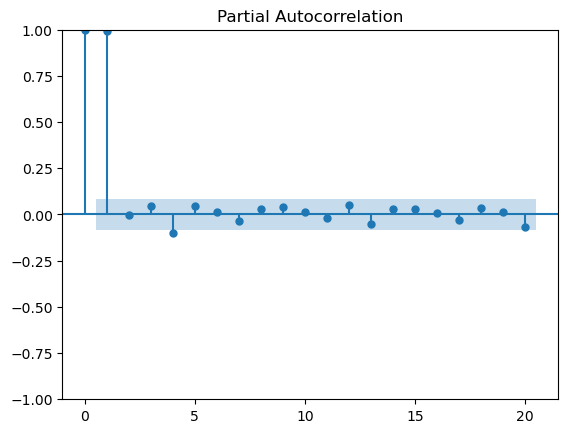

In [9]:
# Partial autocorrelation is a statistical measure in time series analysis that represents the correlation between an observation 
# and its lagged values, while accounting for the influence of all the intervening lags, essentially isolating the direct 
# relationship between two points in time without the effect of other intermediary observations

sm.graphics.tsa.plot_pacf(df_corn['Close'], lags = 20)
plt.show()

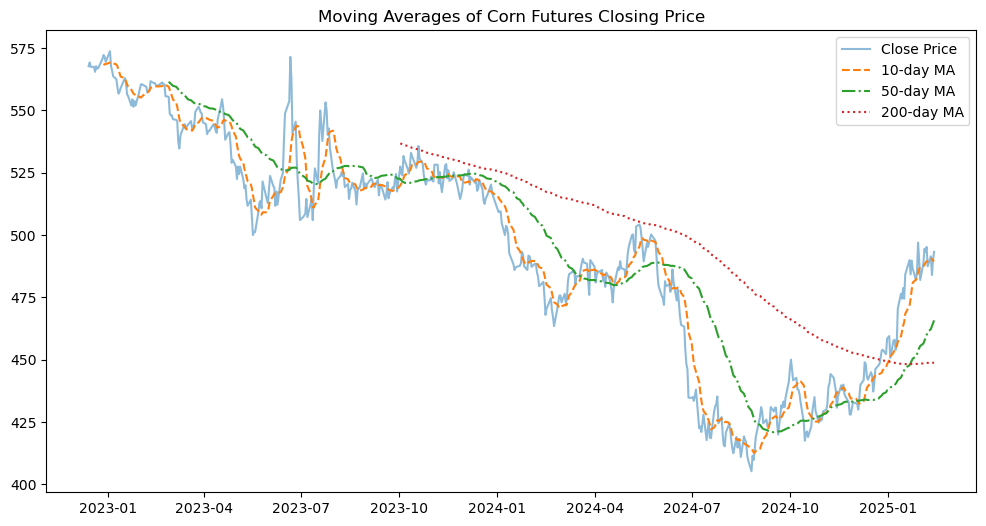

In [10]:
# Moving Averages
df_corn["MA_10"] = df_corn["Close"].rolling(window=10).mean()
df_corn["MA_50"] = df_corn["Close"].rolling(window=50).mean()
df_corn["MA_200"] = df_corn["Close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_corn["Close"], label="Close Price", alpha=0.5)
plt.plot(df_corn["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_corn["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_corn["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Corn Futures Closing Price")
plt.show()

In [11]:
# for seasonal decomposition
from statsmodels.tsa.seasonal import STL

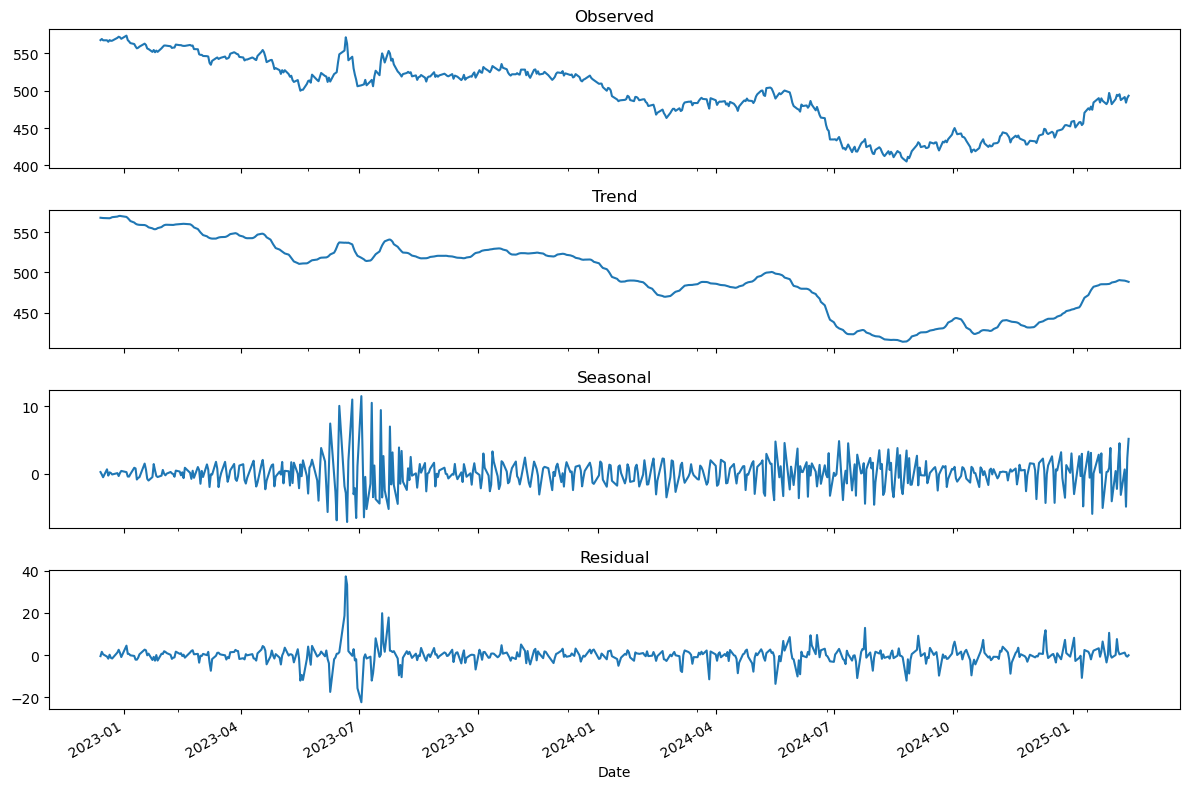

In [12]:
# Seasonal Decomposition (Using STL)
stl = STL(df_corn["Close"], period=5,robust=True)  # 5 day period (since weekends are excluded)
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()


# Wheat

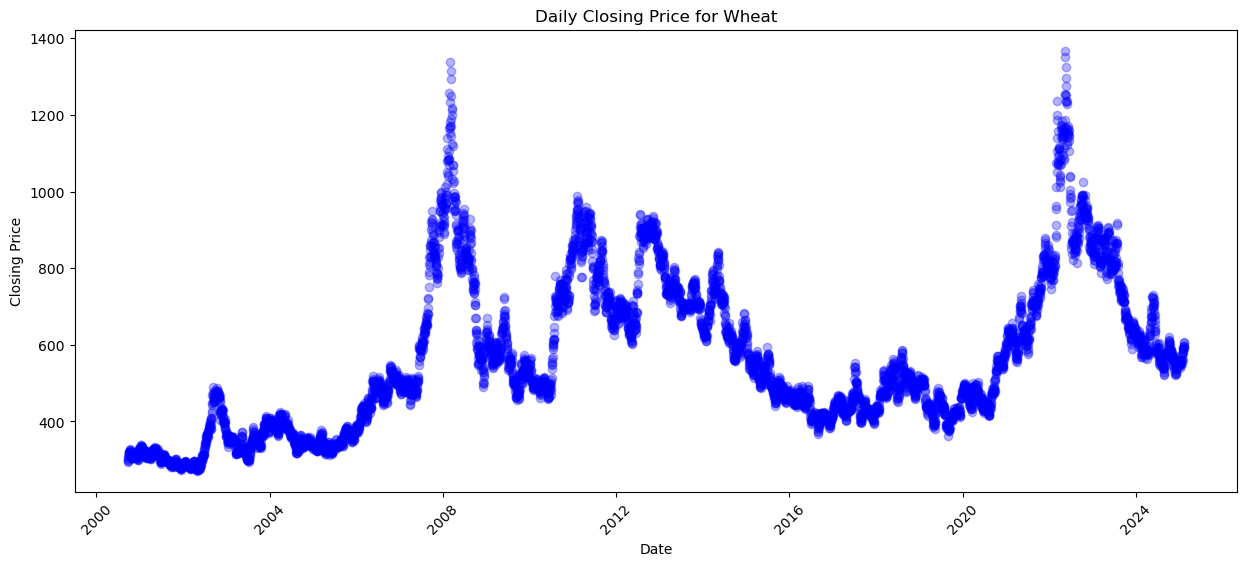

In [13]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_wheat.index, df_wheat['Close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Wheat')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [14]:
rolling_sigmas_wheat = volatilities(df_wheat,n=365)

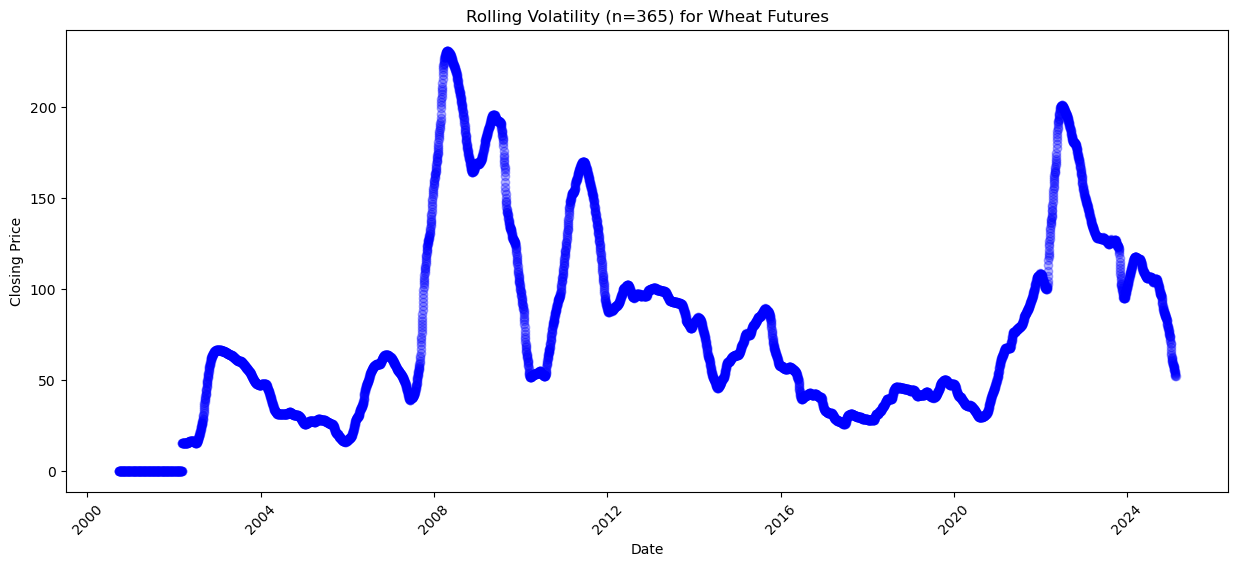

In [15]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_wheat.index, rolling_sigmas_wheat, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=365) for Wheat Futures')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

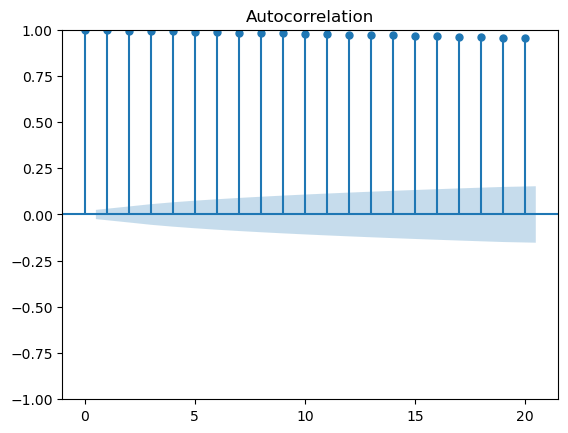

In [16]:
sm.graphics.tsa.plot_acf(df_wheat['Close'], lags = 20)
plt.show()

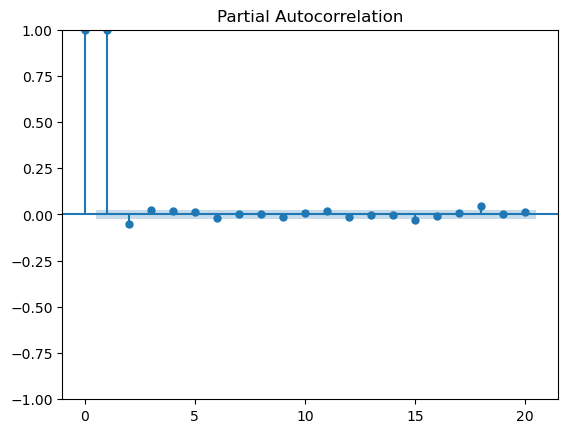

In [17]:
sm.graphics.tsa.plot_pacf(df_wheat['Close'], lags = 20)
plt.show()

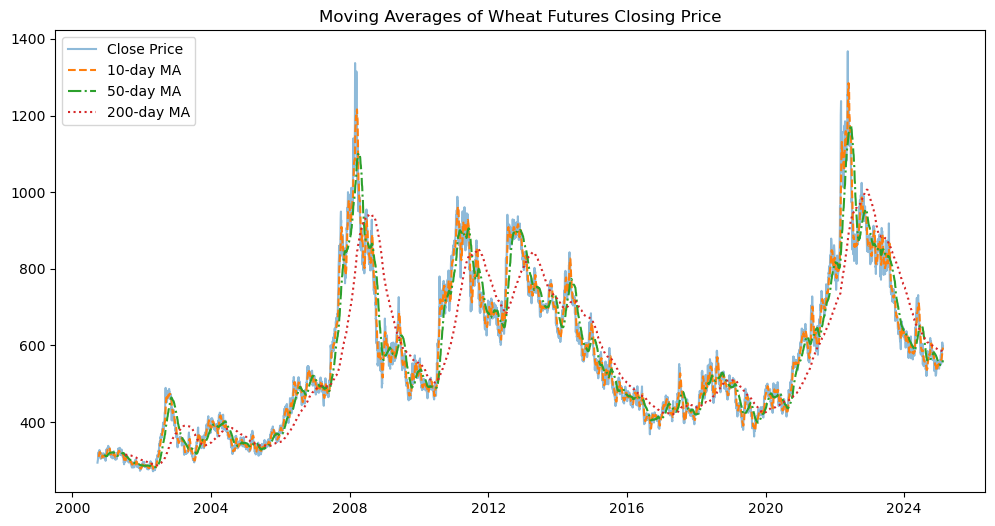

In [18]:
# Moving Averages
df_wheat["MA_10"] = df_wheat["Close"].rolling(window=10).mean()
df_wheat["MA_50"] = df_wheat["Close"].rolling(window=50).mean()
df_wheat["MA_200"] = df_wheat["Close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_wheat["Close"], label="Close Price", alpha=0.5)
plt.plot(df_wheat["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_wheat["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_wheat["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Wheat Futures Closing Price")
plt.show()

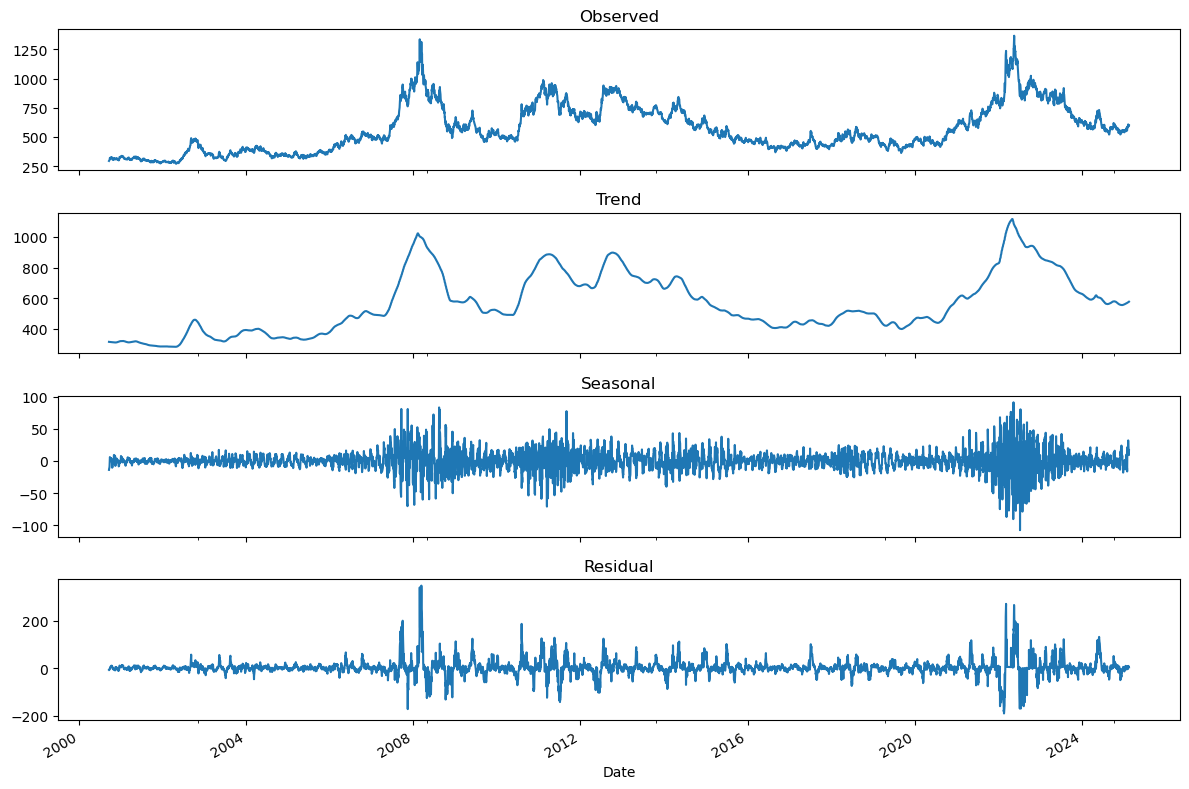

In [19]:
# Seasonal Decomposition (Using STL)
stl = STL(df_wheat["Close"], period=40,robust=True)  # 40 day period
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()

In [ ]:
# from John
# from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
# Convert index to numerical values for FFT
# data["Days"] = (data.index - data.index[0]).days  # Convert dates to numerical values

# Get Close Prices
# close_prices = data["Close"].values
# n = len(close_prices)  # Number of data points

# Compute FFT
#fft_values = rfft(close_prices, axis = 0)
#frequencies = rfftfreq(n, d=1)  # d=1 assumes daily data intervals

# Take absolute value of FFT (magnitude)
#fft_magnitude = np.abs(fft_values)

# # Only look at the first half (since FFT is symmetric)
# half_n = n // 2
# frequencies = frequencies[:half_n]
# fft_magnitude = fft_magnitude[:half_n]

#plt.figure(figsize=(12, 6))
#plt.scatter(frequencies, fft_magnitude, label="FFT Magnitude", )
#plt.xlabel("Frequency (1/days)")
#plt.ylabel("Magnitude")
#plt.xlim(1/365,30/365)
#plt.ylim(0,5000)
#plt.title("Fourier Transform of Corn Futures (ZCH25)")
#plt.legend()
#plt.grid()
#plt.show()

#1/frequencies[6]